In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210524'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 10.60it/s]


(633996, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(631435, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강동구'
target_dong = '성내동'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(574, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
9758,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,31.50,24.75,37700,6,2018.0,2.0,2020-07-31,1196.825397,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동
9759,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,36.90,25.62,38700,4,2018.0,3.0,2021-01-09,1048.780488,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동
9808,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,43.47,26.13,31000,2,2018.0,2.0,2020-01-18,713.135496,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동
9809,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,55.56,33.40,37900,2,2018.0,2.0,2020-01-31,682.145428,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동
9810,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,42.96,25.83,34000,2,2018.0,2.0,2020-03-25,791.433892,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(574, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
9758,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,31.50,24.75,37700,6,2018.0,2.0,2020-07-31,1196.825397,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동,1286.456351,2021-03-01
9759,서울특별시 강동구 성내동 458-1,성내로6나길 8,한강파크빌,36.90,25.62,38700,4,2018.0,3.0,2021-01-09,1048.780488,3.0,대,393.3,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),강동구,성내동,1056.830864,2021-03-01
9808,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,43.47,26.13,31000,2,2018.0,2.0,2020-01-18,713.135496,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동,813.755015,2021-03-01
9809,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,55.56,33.40,37900,2,2018.0,2.0,2020-01-31,682.145428,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동,778.392419,2021-03-01
9810,서울특별시 강동구 성내동 206-1,천호대로168나길 29,성내애스테이1차,42.96,25.83,34000,2,2018.0,2.0,2020-03-25,791.433892,3.0,대,966.0,제2종일반주거지역,지정되지않음,다세대,평지,삼각형,세로한면(가),강동구,성내동,894.262581,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

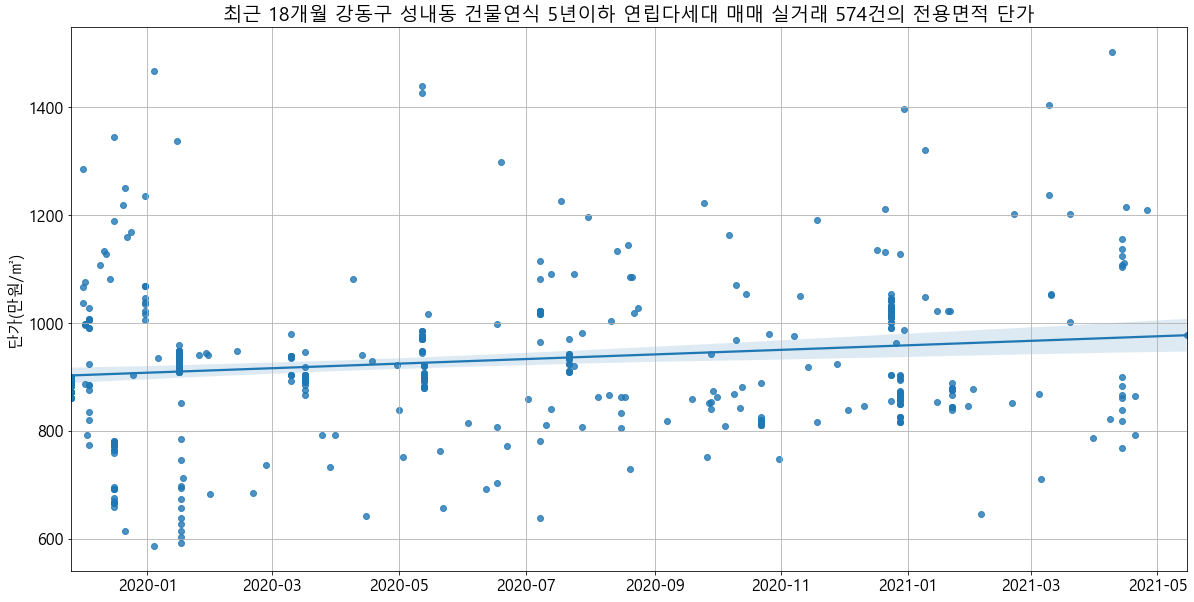

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [20]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

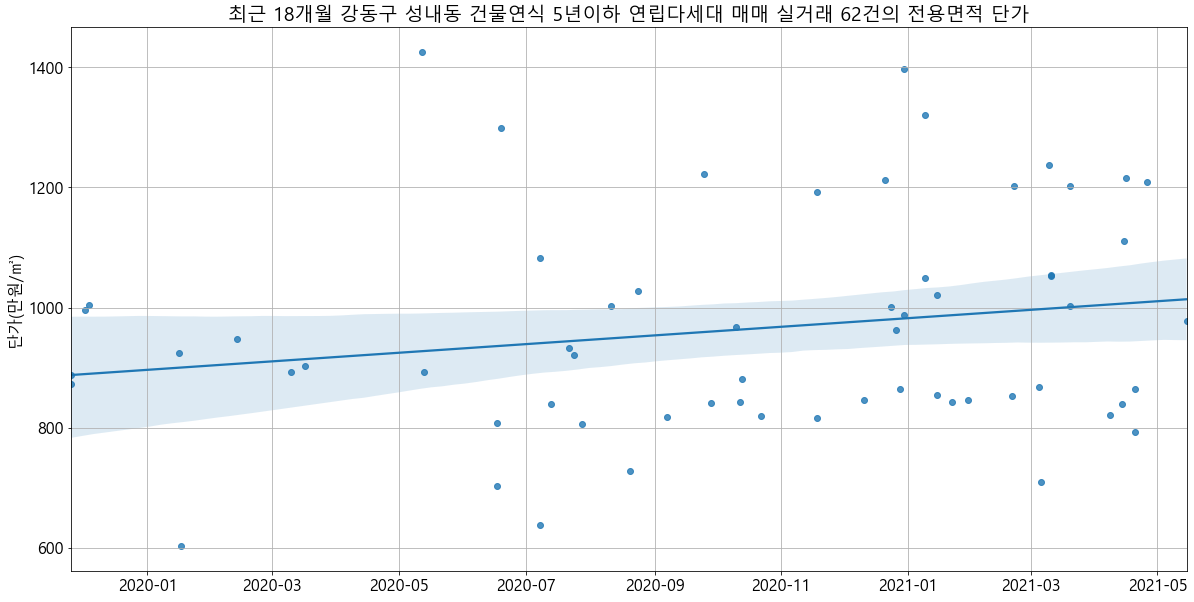

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [22]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [23]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(3143, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
8796,서울특별시 강동구 성내동 147-3,천호대로162가길 11,아름채2,30.37,18.83,25500,4,2016.0,0.0,2016-11-21,839.644386,5.0,대,507.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),강동구,성내동
8797,서울특별시 강동구 성내동 147-3,천호대로162가길 11,아름채2,44.21,24.41,31900,5,2016.0,0.0,2016-12-05,721.556209,5.0,대,507.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),강동구,성내동
8798,서울특별시 강동구 성내동 147-3,천호대로162가길 11,아름채2,30.37,18.83,25300,5,2016.0,0.0,2016-12-05,833.058940,5.0,대,507.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),강동구,성내동
8799,서울특별시 강동구 성내동 147-3,천호대로162가길 11,아름채2,31.89,19.77,27800,3,2016.0,0.0,2016-12-10,871.746629,5.0,대,507.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),강동구,성내동
8800,서울특별시 강동구 성내동 147-3,천호대로162가길 11,아름채2,35.40,21.95,28800,4,2016.0,0.0,2016-12-16,813.559322,5.0,대,507.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),강동구,성내동


In [24]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강동구 성내동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 3143건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

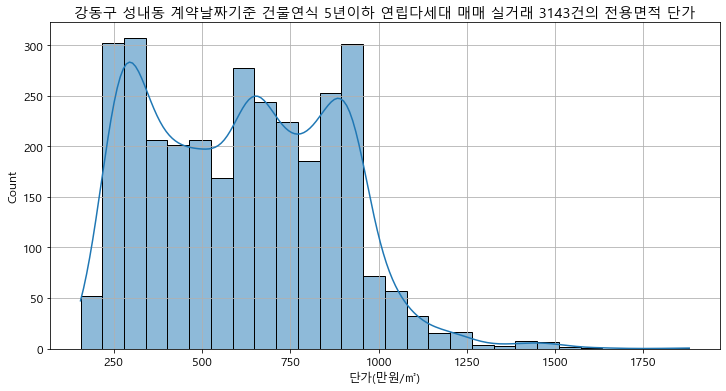

In [25]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [26]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [27]:
concat_df = pd.concat([target_df2])

In [28]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [29]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [30]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(1423, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 성내동 117-29,올림픽로58길 6,(117-29),18.08,12.66,11200,4,2015.0,2.0,2017-04-20,619.469027,6.0,대,155.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,세로각지(가),강동구,성내동,800.469326,2021-03-01,644.911920,833.346281
1,서울특별시 강동구 성내동 117-29,올림픽로58길 6,(117-29),37.44,26.21,23600,4,2015.0,2.0,2017-04-20,630.341880,6.0,대,155.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,세로각지(가),강동구,성내동,814.519077,2021-03-01,644.911920,833.346281
2,서울특별시 강동구 성내동 117-29,올림픽로58길 6,(117-29),39.54,27.33,28000,5,2015.0,2.0,2017-04-20,708.143652,6.0,대,155.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,세로각지(가),강동구,성내동,915.053453,2021-03-01,644.911920,833.346281
3,서울특별시 강동구 성내동 117-29,올림픽로58길 6,(117-29),45.36,31.75,28200,2,2015.0,2.0,2017-04-20,621.693122,6.0,대,155.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,세로각지(가),강동구,성내동,803.343271,2021-03-01,644.911920,833.346281
4,서울특별시 강동구 성내동 118-11,천호옛길 51,(118-11),23.70,12.06,13000,4,2004.0,5.0,2009-07-27,548.523207,17.0,대,274.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,중로한면,강동구,성내동,741.046019,2021-03-01,499.258403,674.490062


In [31]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(395, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
3,서울특별시 강동구 성내동 117-29,올림픽로58길 6,(117-29),45.360,31.75,28200,2,2015.0,2.0,2017-04-20,621.693122,6.0,대,155.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,세로각지(가),강동구,성내동,803.343271,2021-03-01,644.911920,833.346281
9,서울특별시 강동구 성내동 118-11,천호옛길 51,(118-11),86.290,43.91,50000,5,2004.0,5.0,2009-07-27,579.441418,17.0,대,274.0,제3종일반주거지역,지정되지않음,주상용,평지,사다리형,중로한면,강동구,성내동,782.816025,2021-03-01,499.258403,674.490062
17,서울특별시 강동구 성내동 118-17,천호옛길 45,런던빌,59.850,30.60,32000,2,2015.0,2.0,2017-07-19,534.670008,6.0,대,302.0,제3종일반주거지역,지정되지않음,주상용,평지,세로장방,중로각지,강동구,성내동,670.781434,2021-03-01,564.529143,752.007399
25,서울특별시 강동구 성내동 118-34,올림픽로58길 21-4,경지 성내 아리움,42.400,21.13,28500,4,2016.0,0.0,2016-07-30,672.169811,5.0,대,317.0,제3종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강동구,성내동,902.147233,2021-03-01,862.840392,1118.664613
30,서울특별시 강동구 성내동 118-45,올림픽로58길 21-16,삼성아트빌,52.090,29.76,32000,4,2015.0,4.0,2019-07-25,614.321367,6.0,대,166.0,제3종일반주거지역,지정되지않음,다세대,평지,자루형,세로한면(가),강동구,성내동,715.028480,2021-03-01,665.509691,788.119865
33,서울특별시 강동구 성내동 12-13,천호옛14길 23-16,뜨라네(12-13),41.830,20.23,39700,7,2016.0,2.0,2018-05-24,949.079608,5.0,대,352.0,제3종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강동구,성내동,1163.869844,2021-03-01,1012.125269,1220.086611
34,서울특별시 강동구 성내동 12-15,천호옛14길 31-22,천호역 아름채2,22.240,10.85,36200,6,2017.0,1.0,2018-01-30,1627.697842,4.0,대,375.0,제3종일반주거지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),강동구,성내동,2035.307490,2021-03-01,1627.697842,2035.307490
39,서울특별시 강동구 성내동 12-17,천호옛14길 31-20,천호역 아름채,29.950,14.29,36000,4,2017.0,4.0,2021-02-21,1202.003339,4.0,대,435.0,제3종일반주거지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),강동구,성내동,1215.249942,2021-03-01,1215.943713,1443.422351
47,서울특별시 강동구 성내동 127-13,천호옛8길 3,WISH희망,41.740,26.72,39150,4,2020.0,0.0,2020-07-22,937.949209,1.0,대,109.0,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(가),강동구,성내동,1008.192774,2021-03-01,932.524687,1002.362006
50,서울특별시 강동구 성내동 127-6,천호옛길 52-7,노블하우스,27.530,17.15,23500,3,2017.0,0.0,2017-08-28,853.614239,4.0,대,126.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),강동구,성내동,1080.903639,2021-03-01,1097.229886,1212.025459


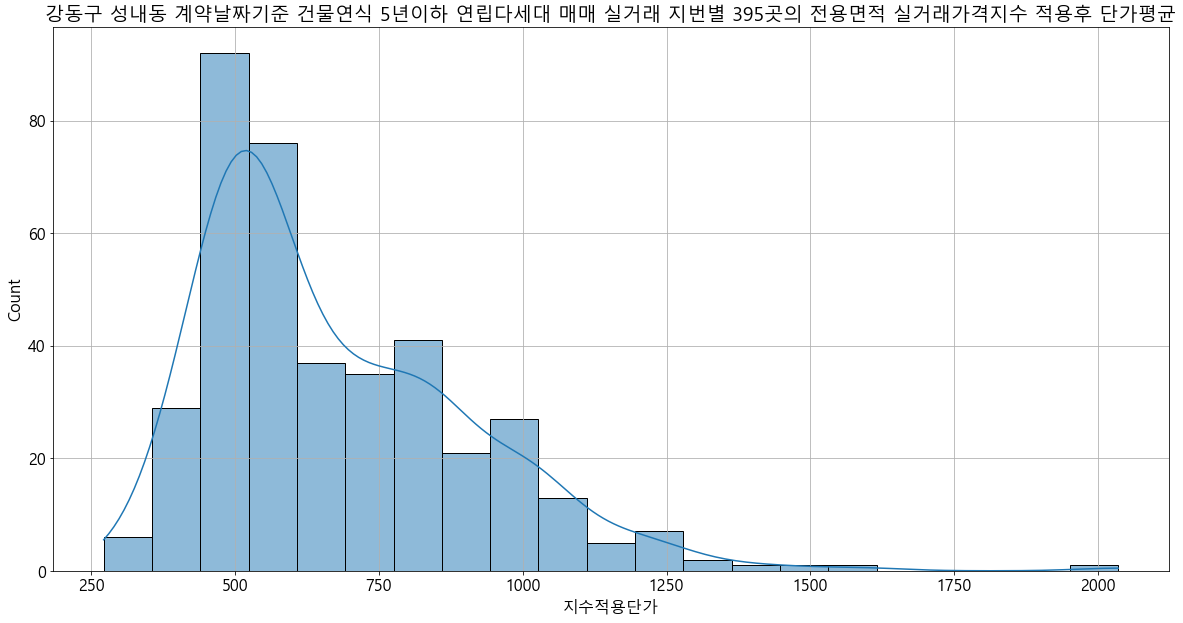

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [33]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [34]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1
0,서울특별시 강동구 성내동 117-29,(117-29),2015.0,45.36,2017-04-20,621.693122,2021-03-01,803.343271,제3종일반주거지역
1,서울특별시 강동구 성내동 118-11,(118-11),2004.0,86.29,2009-07-27,579.441418,2021-03-01,782.816025,제3종일반주거지역
2,서울특별시 강동구 성내동 118-17,런던빌,2015.0,59.85,2017-07-19,534.670008,2021-03-01,670.781434,제3종일반주거지역
3,서울특별시 강동구 성내동 118-34,경지 성내 아리움,2016.0,42.40,2016-07-30,672.169811,2021-03-01,902.147233,제3종일반주거지역
4,서울특별시 강동구 성내동 118-45,삼성아트빌,2015.0,52.09,2019-07-25,614.321367,2021-03-01,715.028480,제3종일반주거지역


In [35]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)